# Download and unzip the dataset of faces only Images

In [8]:
!pip install gdown
!gdown --fuzzy https://drive.google.com/file/d/1-Irv4OIJfa64fgcSnu_mJvWRgSuX5N0D/view?usp=sharing
!gdown --fuzzy https://drive.google.com/file/d/1AM_HIiEf5r4t9QqOIE9WAYzFESREKFWL/view?usp=sharing

Downloading...
From (original): https://drive.google.com/uc?id=1-Irv4OIJfa64fgcSnu_mJvWRgSuX5N0D
From (redirected): https://drive.google.com/uc?id=1-Irv4OIJfa64fgcSnu_mJvWRgSuX5N0D&confirm=t&uuid=2fa0e828-3091-4ef9-88d5-889ccf1053bd
To: /kaggle/working/All fake videos faces only.zip
100%|███████████████████████████████████████| 35.0M/35.0M [00:00<00:00, 168MB/s]
Downloading...
From: https://drive.google.com/uc?id=1AM_HIiEf5r4t9QqOIE9WAYzFESREKFWL
To: /kaggle/working/All real videos faces only.zip
100%|███████████████████████████████████████| 18.9M/18.9M [00:00<00:00, 218MB/s]


!unzip '/kaggle/working/All real videos faces only.zip' -d '/kaggle/working/data'
!unzip '/kaggle/working/All fake videos faces only.zip' -d '/kaggle/working/data/fake' 

In [ ]:
!unzip '/kaggle/working/All real videos faces only.zip' -d '/kaggle/working/data'
!unzip '/kaggle/working/All fake videos faces only.zip' -d '/kaggle/working/data/fake' 

In [12]:
print(f"{len(os.listdir('/kaggle/working/data/real'))} Real faces")
print(f"{len(os.listdir('/kaggle/working/data/fake'))} Fake faces")

1934 Real faces
4056 Fake faces


# Import required dependencies

In [13]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications import ResNet50, InceptionV3, MobileNetV2, VGG19
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D, Dropout, Flatten
import matplotlib.pyplot as plt
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping
import os, shutil
import matplotlib.pyplot as plt

In [32]:
main_dir = '/kaggle/working/data'
# Define image size and batch size
img_size = (224, 224)
batch_size = 32

datagen = ImageDataGenerator(
    rescale=1./255,
    # horizontal_flip = True,
    # vertical_flip = True,
    # rotation_range=0.4,
    validation_split=0.2,# Splitting the data into 80% training and 20% validation
)

In [33]:
# Create flow_from_directory generator using the main directory and splitting it
train_generator = datagen.flow_from_directory(
    main_dir,
    target_size=img_size,
    batch_size=batch_size,
    class_mode='binary',  # For 2 classes
    subset='training'  # Indicates this generator is for training
)

Found 4793 images belonging to 2 classes.


In [34]:
validation_generator = datagen.flow_from_directory(
    main_dir,
    target_size=img_size,
    batch_size=batch_size,
    class_mode='binary',  # For 2 classes
    subset='validation'  # Indicates this generator is for validation
)

Found 1197 images belonging to 2 classes.


In [35]:
# Load pre-trained ResNet50 without the top (fully connected) layers
base_model = InceptionV3(weights='imagenet', include_top=False)
# base_model = ResNet50(weights='imagenet', include_top=False)

# Create a new model on top of ResNet50
model = Sequential()
model.add(base_model)
model.add(Flatten())
model.add(Dense(64, activation='relu'))
model.add(Dropout(0.2))
model.add(Dense(256, activation='relu'))
model.add(Dropout(0.3))
model.add(Dense(1, activation='sigmoid'))

i = 0
for layer in base_model.layers:
    layer.trainable = True

In [36]:
# Compile the model
model.compile(optimizer='adam',
              loss='binary_crossentropy',
              metrics=['accuracy'])
checkpoint_path = '/kaggle/working/best_model.keras'
checkpoint = ModelCheckpoint(checkpoint_path, monitor='val_accuracy', verbose=1, save_best_only=True, mode='max')
early_stop = EarlyStopping(monitor='val_accuracy', patience=3, mode='max', verbose=1)

# Train the model

In [37]:
history = model.fit(
    train_generator,
    epochs=30,
    validation_data=validation_generator,
    callbacks=[checkpoint]#, early_stop]
)

Epoch 1/30
150/150 ━━━━━━━━━━━━━━━━━━━━ 0s 640ms/step - accuracy: 0.6246 - loss: 0.9687
Epoch 1: val_accuracy improved from -inf to 0.67753, saving model to /kaggle/working/best_model.keras
150/150 ━━━━━━━━━━━━━━━━━━━━ 221s 783ms/step - accuracy: 0.6248 - loss: 0.9673 - val_accuracy: 0.6775 - val_loss: 0.6477
Epoch 2/30
150/150 ━━━━━━━━━━━━━━━━━━━━ 0s 227ms/step - accuracy: 0.6792 - loss: 0.6314
Epoch 2: val_accuracy did not improve from 0.67753
150/150 ━━━━━━━━━━━━━━━━━━━━ 37s 242ms/step - accuracy: 0.6792 - loss: 0.6314 - val_accuracy: 0.6775 - val_loss: 0.6309
Epoch 3/30
150/150 ━━━━━━━━━━━━━━━━━━━━ 0s 225ms/step - accuracy: 0.6727 - loss: 0.6331
Epoch 3: val_accuracy did not improve from 0.67753
150/150 ━━━━━━━━━━━━━━━━━━━━ 37s 241ms/step - accuracy: 0.6727 - loss: 0.6330 - val_accuracy: 0.6775 - val_loss: 0.6292
Epoch 4/30
150/150 ━━━━━━━━━━━━━━━━━━━━ 0s 226ms/step - accuracy: 0.6775 - loss: 0.6291
Epoch 4: val_accuracy did not improve from 0.67753
150/150 ━━━━━━━━━━━━━━━━━━━━ 37s

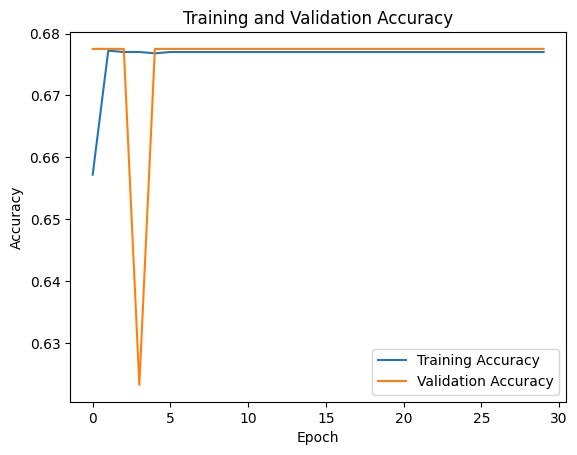

In [38]:
# Plot training and validation accuracy
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Training and Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

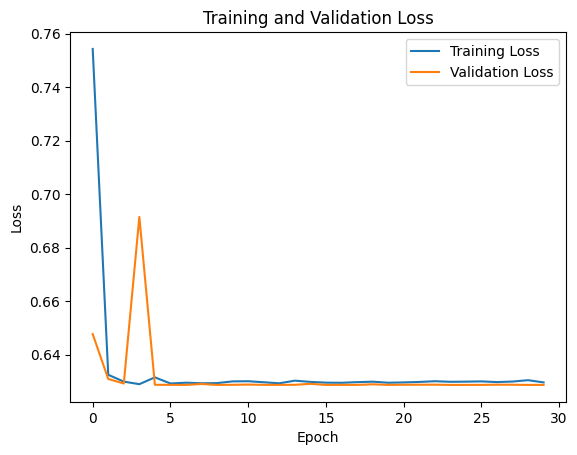

In [39]:
# Plot training and validation loss
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()